# Image clustering by texture

In [2]:
import os
import sys
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVR
from skimage import feature as skft
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from sklearn import cluster

## Image preparation

In [4]:
image_dir = '../datasets/General_train/General_train/'
MAX_NUM_IMAGE = 50

In [5]:
def _slice_(image, size, stride):
    """
    Slice the image into blocks with stride, which could be reconstructed.
    Input:
        image : ndarray, 2-D or 3-D numpy array
        size : int, size of block
        stride : int, stride of slicing. 
    Return:
        N : int, number of blocks.
        data : ndarray, numpy array with shape of (N, size, size, channel), and channel will be 1 if image is in grayscale.
        (nx, ny) : tuple of two integers, used to merge original image.
    """
    blocks = []
    nx = ny = 0
    h, w = image.shape[0:2]
    if len(image.shape) == 2:
        image = image.reshape((h, w, 1))

    for x in range(0, h - size + 1, stride):
        nx += 1
        ny = 0
        for y in range(0, w - size + 1, stride):
            ny += 1
            subim = image[x : x + size, y : y + size, :]        
            blocks.append(subim)
    N = len(blocks)
    data = np.array(blocks)
    return N, data, (nx, ny)

In [6]:
def load_pic(image_dir):
    for i, filename in enumerate(sorted(os.listdir(image_dir))):
        if i >= MAX_NUM_IMAGE:
            break
        image = imread(os.path.join(image_dir, filename), 'F')
        N, data, _ = _slice_(image, 48, 24)
        if i == 0:
            blocks = data
        blocks = np.concatenate((blocks, data))
            
        sys.stdout.write("\r...%d image has sliced, %d remaind..."%(i+1, MAX_NUM_IMAGE-i-1))
    return blocks
        

In [7]:
blocks = load_pic(image_dir)

/home/mulsn/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


...50 image has sliced, 0 remaind....

In [8]:
print(blocks.shape)

(8199, 48, 48, 1)


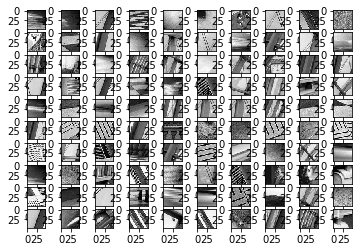

In [9]:
# sample some blocks to show
sample_size = 100

np.random.seed(0)
index_show = np.random.randint(5984, size=sample_size)
blocks_show = blocks[index_show]
x = y = int(np.sqrt(sample_size))
for i in range(sample_size):
    plt.subplot(x,y,i+1)
    plt.imshow(blocks_show[i].squeeze(), 'gray')
plt.show()

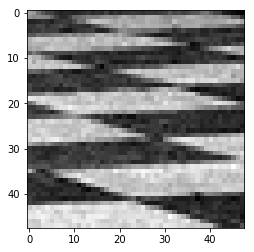

In [10]:
# 3264st block
plt.imshow(blocks[3264].squeeze(), 'gray')
plt.show()

## Image feature extraction by LBP

In [11]:
# Not understood yet. 

def texture_detect(data):
    radius = 1;
    n_point = radius * 8;
    data = data.squeeze()
    num_data = data.shape[0]
    train_hist = np.zeros( (num_data,256) );
    for i in np.arange(num_data):
        #使用LBP方法提取图像的纹理特征.
        lbp=skft.local_binary_pattern(data[i],n_point,radius,'default');
        #统计图像的直方图
        max_bins = int(lbp.max() + 1);
        #hist size:256
        train_hist[i], _ = np.histogram(lbp, normed=True, bins=max_bins, range=(0, max_bins));

    return train_hist

In [12]:
train_hist = texture_detect(blocks);

In [13]:
train_hist.shape

(8199, 256)

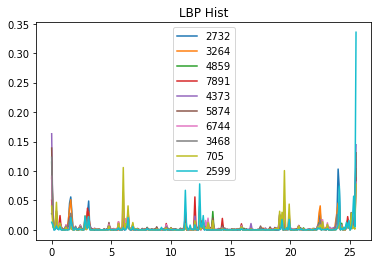

In [14]:
# sample 10 hist to show

np.random.seed(0)
x = np.arange(0, 25.6, 0.1)
index = np.random.randint(8199, size=10)
legend = []
for i in index:
    y = train_hist[i]
    legend.append(str(i))
    plt.plot(x, y)
plt.legend(legend)
plt.title('LBP Hist')
# Plot the points using matplotlib
plt.show() 

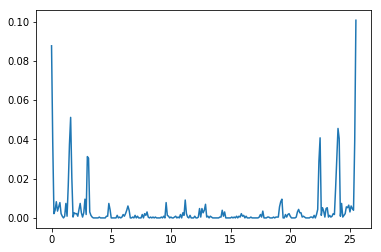

In [15]:
# 3264st hist
x = np.arange(0, 25.6, 0.1)
y = train_hist[3264]
plt.plot(x, y)
plt.show()


## Clustering

In [16]:
# 生成10*3的矩阵
data = train_hist[:1000]
# print (data)
# 聚类为4类
estimator=KMeans(n_clusters=10)
# fit_predict表示拟合+预测，也可以分开写
res=estimator.fit_predict(data)
# 预测类别标签结果
lable_pred=estimator.labels_
# 各个类别的聚类中心值
centroids=estimator.cluster_centers_
# 聚类中心均值向量的总和
inertia=estimator.inertia_
 
# print (lable_pred)
# print (centroids)
# print (inertia)

# for i in range(len(data)):
#     if int(lable_pred[i])==0:
#         plt.scatter(data[i][0],data[i][1],color='red')
#     if int(lable_pred[i])==1:
#         plt.scatter(data[i][0],data[i][1],color='black')
#     if int(lable_pred[i])==2:
#         plt.scatter(data[i][0],data[i][1],color='blue')
# plt.show()

In [17]:
# print (lable_pred)
# print (centroids)
# print (inertia)

In [18]:
# print(len(np.where(lable_pred == 0)[0]))

<function matplotlib.pyplot.show(*args, **kw)>

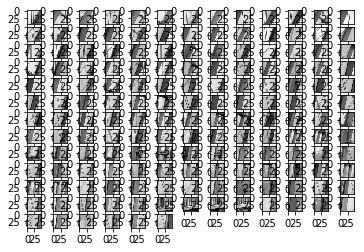

In [20]:
block_classes = []
for i in range(10):
    block_classes.append(blocks[np.where(lable_pred==i)[0]])

index_class = 1
block_class = block_classes[index_class]
print('%d images in class %d'%(len(block_class), index_class))
for i in range(len(block_class)):
    length = len(block_class)
    x = y = np.sqrt(length)+1
    plt.subplot(x, y, i+1)
    plt.imshow(block_class[i].squeeze(), 'gray')
plt.show